https://www.kaggle.com/keremt/pytorch-entity-embeddings was super helpful with this.

In [1]:
import gc
import os
import random
from pathlib import Path
from typing import Union, List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torch.optim import SGD

import numpy as np
import pandas as pd
import skopt

import matplotlib.pyplot as plt
%matplotlib inline

Seed random number generators for reproducibility.

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything()

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# PyTorch Dataset

In [4]:
class EimDataset(Dataset):
    """
    Subclass of a PyTorch Dataset. Categorical and continuous variables are stored 
    as NumPy arrays, as is the output variable. If no categorical variables are 
    provided, an array of zeros as long as the number of continuous variables is 
    stored for each observation's categorical variables. This is similar for 
    continuous variables. If an output variable (y) is not provided, a zero is 
    stored for the output for each observation.
    
    When asked for an item a list like [categorical_vars, continuous_vars, output] 
    is returned for the item.
    """    
    cats: np.ndarray
    conts: np.ndarray
    y: np.ndarray
    
    def __init__(self, cats: np.ndarray, conts: np.ndarray, y: np.ndarray) -> 'EimDataset':
        n = len(cats[0]) if cats else len(conts[0])
        self.cats = np.stack(cats, 1).astype(np.int64) if cats else np.zeros((n,1))
        self.conts = np.stack(conts, 1).astype(np.float32) if conts else np.zeros((n,1))
        self.y = np.zeros((n,1)) if y is None else y[:,None].astype(np.float32)
        
    def __len__(self) -> int: return len(self.y)

    def __getitem__(self, idx) -> List[np.ndarray]:
        return [self.cats[idx], self.conts[idx], self.y[idx]]
    
    @classmethod
    def from_data_frames(cls, df_cat: pd.DataFrame, df_cont: pd.DataFrame, y: pd.Series=None):
        cat_cols = [c.values for n,c in df_cat.items()]
        cont_cols = [c.values for n,c in df_cont.items()]
        return cls(cat_cols, cont_cols, y)

    @classmethod
    def from_data_frame(cls, df: pd.DataFrame, cat_flds: List[str], cont_flds: List[str], y=None):
        return cls.from_data_frames(df[cat_flds], df[cont_flds], y)

In [5]:
class EimModelData():
    ### This class provides training and validation dataloaders
    ### Which we will use in our model    
    path: Path
    trn_dl: DataLoader
    val_dl: DataLoader
    test_dl: DataLoader
    
    def __init__(self, path: Path, trn_ds: Dataset, val_ds: Dataset, bs: int, test_ds: Dataset=None) -> 'EimModelData': 
        self.path = path
        self.trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True, num_workers=1)
        self.val_dl = DataLoader(val_ds, batch_size=bs, shuffle=True, num_workers=1)
        self.test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=1) if test_ds is not None else None
    
    @classmethod
    def from_data_frames(cls, path: Path, trn_df: pd.DataFrame, val_df: pd.DataFrame, trn_y: Union[pd.DataFrame, pd.Series], 
                         val_y: Union[pd.DataFrame, pd.Series], cat_flds: List[str], cont_flds: List[str], 
                         bs: int, test_df: pd.DataFrame=None) -> 'EimModelData':
        test_ds = EimDataset.from_data_frame(test_df, cat_flds, cont_flds) if test_df is not None else None
        return cls(path, EimDataset.from_data_frame(trn_df, cat_flds, cont_flds, trn_y),
                   EimDataset.from_data_frame(val_df, cat_flds, cont_flds, val_y), bs, test_ds=test_ds)

    @classmethod
    def from_data_frame(cls, path: Path, val_idxs: Union[List[int], np.ndarray], trn_idxs: Union[List[int], np.ndarray], 
                        df: pd.DataFrame, y: Union[pd.DataFrame, pd.Series], cat_flds: List[str], cont_flds: List[str], 
                        bs: int, test_df: pd.DataFrame=None) -> 'EimModelData':
        val_df, val_y = df.iloc[val_idxs], y[val_idxs]
        trn_df, trn_y = df.iloc[trn_idxs], y[trn_idxs]
        return cls.from_data_frames(path, trn_df, val_df, trn_y, val_y, cat_flds, cont_flds, bs, test_df)

# Model

In [6]:
class EimModel(nn.Module):
    """
    EiM learning model that supports embedding layers for categorical features.
    """
    
    def __init__(self, emb_szs: List[Tuple[int, int]], n_cont: int, emb_drop: float, out_sz: int, szs: List[int], 
                 drops: List[float], y_range: List[float]=None, use_bn: bool=False, classify: bool=None) -> 'EimModel':
        """
        Creates a neural network model that supports embedding layers for categorical features. Dropout and batch norm 
        layers can be used following embedding layers and fully connected layers. Can be used for regression or 
        classification.
        
        Parameters
        ----------
        emb_szs : list of (int, int) tuples
            The list of embedding sizes to use. Order of tuples should correspond to the order in which
            categorical features will be passed to the model in training. The first item in the tuple 
            should be the number of unique values for the category, and the second item should be the 
            number of embedding dimensions to use for the catgory.
        n_cont : int
            The number of continuous features that will be passed to the model.
        emb_drop : float
            The dropout probability that should be used for the embedding layers.
        out_sz : int
            The number of nodes in the output later.
        szs : list of ints
            The number of nodes in each hidden, fully connected layer.
        drops : list of floats
            The dropout probability for each fully connected layer.
        y_range : list of (float, float)
            For regression, the min (y_range[0]) and max (y_range[1]) values that the output can take.
        use_bn : bool
            If true, batch norm layers will be used following the embedding and fully connected layers.
        classify : bool
            If true, model will be configured for classification.
        
        Construction:
        - Starts by creating an embedding layer (in self.embs) for each size given in emb_szs
        - Initializes the weights of each embedding layer uniformly randomly (The width of this 
          distribution is inversely proportional to the size of the embedding dimension--see 
          `emb_init`)
        - Adds up the size of all embedding dimensions
        - Adds to this count the number of continuous variables
        - Adds this total to the beginning of the szs list (in order to create the whole input layer in front of the first hidden layer)
        - Creates a list of linear layers as specified by szs--these are stored in self.lins
        - Creates a list of batch norm layers to follow each hidden layer--these are stored in self.bns
        - Performs Kaiming initialization on each batch norm layer
        - Creates a dropout layer after each hidden layer and after the embedding portion of the input layer
        - Creates a batch norm layer to follow the continuous portion of the input layer
        """
        super().__init__() ## inherit from nn.Module parent class
        self.embs = nn.ModuleList([nn.Embedding(m, d) for m, d in emb_szs]) ## construct embeddings
        for emb in self.embs: emb_init(emb) ## initialize embedding weights
        n_emb = sum(e.embedding_dim for e in self.embs) ## get embedding dimension needed for 1st layer
        szs = [n_emb+n_cont] + szs ## add input layer to szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)]) ## create linear layers input, l1 -> l1, l2 ...
        
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]]) ## batchnormalization for hidden layers activations
        for o in self.lins: nn.init.kaiming_normal_(o.weight.data) ## init weights with kaiming normalization
        self.outp = nn.Linear(szs[-1], out_sz) ## create linear from last hidden layer to output
        nn.init.kaiming_normal_(self.outp.weight.data) ## do kaiming initialization
        
        self.emb_drop = nn.Dropout(emb_drop) ## embedding dropout, will zero out weights of embeddings
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in [drops] * len(self.lins)])
#         self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops]) ## fc layer dropout
        self.bn = nn.BatchNorm1d(n_cont) # batch norm for continous data
        self.use_bn,self.y_range = use_bn,y_range 
        self.classify = classify
        
    def forward(self, x_cat: torch.Tensor, x_cont: torch.Tensor) -> torch.Tensor:
        """
        Calculate a forward pass for the provided input data.
        
        Parameters
        ----------
        x_cat : PyTorch Tensor
            The categorical inputs, with observations in the rows.
        x_cont PyTorch Tensor
            The categorical inputs, with observations in the rows. The ordering of the observations 
            should match the ordering of observations in `x_cat`.
        
        Forward pass:
        - Passes each column of the categorical input through its corresponding embedding layer; 
          concatenates all these results into a matrix
        - Applies dropout to output of embedding layers
        - Applies batch norm to continuous inputs
        - Concatenates output of embedding dropout and batch norm-ed continuous inputs
        - Passes this matrix through each linear/batch norm/dropout layer
        - If we are classifying, applies sigmoid activation
        - If we are regressing, applies sigmoid activation and then scales to range of output values
        """        
        x = [emb(x_cat[:, i]) for i, emb in enumerate(self.embs)] # takes necessary emb vectors 
        x = torch.cat(x, 1) ## concatenate along axis = 1 (columns - side by side) # this is our input from cats
        x = self.emb_drop(x) ## apply dropout to elements of embedding tensor
        x2 = self.bn(x_cont) ## apply batchnorm to continous variables        
        x = torch.cat([x, x2], 1) ## concatenate cats and conts for final input
        for l, d, b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x)) ## dotprod + non-linearity
            if self.use_bn: x = b(x) ## apply batchnorm activations
            x = d(x) ## apply dropout to activations
        x = self.outp(x) # we defined this externally just not to apply dropout to output
        if self.classify:
            x = torch.sigmoid(x) # for classification
        elif y_range:
            x = torch.sigmoid(x) ## scales the output between 0,1
            x = x*(self.y_range[1] - self.y_range[0]) ## scale output
            x = x + self.y_range[0] ## shift output
        return x

In [7]:
def preprocess(data: pd.DataFrame, cats: List[str]) -> pd.DataFrame:
    data.fillna('missing', inplace=True)
    for c in cats:
        data[c] = data[c].astype('category').cat.codes
    return data

def EimDataPreprocess(data, cats, inplace =True):
    ### Each categorical column should have indices as values 
    ### Which will be looked up at embedding matrix and used in modeling
    ### Make changes inplace
    if inplace:
        for c in cats:
            data[c].replace({val:i  for i, val in enumerate(data[c].unique())}, inplace=True)
        return data
    else:
        data_copy = data.copy()
        for c in cats:
            data_copy[c].replace({val:i  for i, val in enumerate(data_copy[c].unique())}, inplace=True)
        return data_copy
        
def get_embs_dims(data, cats, minimum=2):
    cat_sz = [len(data[c].unique()) for c in cats]
    return [(c, max(min(50, (c+1)//2 + 1), minimum)) for c in cat_sz]
    
def emb_init(x):
    x = x.weight.data
    sc = 2/(x.size(1)+1)
    x.uniform_(-sc,sc)

# Data processing

In [9]:
eim_csv = Path('..', '..', 'fastai', 'data', 'good_reaction_trials_categorified.csv')

eim_df = pd.read_csv(eim_csv)
train_df = eim_df[eim_df.song == 'into_dust'].copy()
test_df = eim_df[eim_df.song != 'into_dust'].copy()

del eim_df

# train_df = train_df.iloc[0:128]
train_df.head()

,_id,location,sex,musical_background,nationality,visual_impairments,musical_expertise,hearing_impairments,age,critical_reaction,...,musicpref_jazz,musicpref_folk,musicpref_hiphop,musicpref_classical,musicpref_none,musicpref_rock,musicpref_hip_hop,musicpref_world,musicpref_pop,musicpref_dance
395,5410f69408ad6ee3090e3881,dublin,male,0,irish,0,0,1,41.0,False,...,0,0,0,0,0,1,0,0,1,0
396,5410f69408ad6ee3090e3886,dublin,male,0,irish,0,0,0,41.0,False,...,0,0,0,0,0,1,0,0,1,0
397,5410f69608ad6ee3090e38a4,dublin,female,0,irish,0,0,0,21.0,False,...,0,0,0,1,0,0,0,0,1,0
398,5410f71408ad6ee3090e3aca,dublin,male,1,irish,0,3,0,25.0,False,...,0,0,0,0,0,1,0,1,1,1
399,5410f7b408ad6ee3090e3d12,dublin,female,0,irish,0,0,0,21.0,False,...,0,0,0,0,0,0,1,0,1,0


In [11]:
cats = ['location', 'sex', 'musical_background', 'nationality', 'visual_impairments', 'hearing_impairments', 
        'musicpref_traditional_irish', 'musicpref_jazz', 'musicpref_folk', 'musicpref_hiphop', 'musicpref_classical', 
        'musicpref_none', 'musicpref_rock', 'musicpref_hip_hop', 'musicpref_world', 'musicpref_pop', 'musicpref_dance',
        'language']

conts = ['musical_expertise', 'age', 'control_activity', 'control_tension', 'control_engagement', 
         'control_positivity', 'control_like_dislike', 'song_chillsshiversthrills', 'song_activity', 'song_tension', 
         'song_familiarity', 'song_engagement', 'song_positivity', 'song_like_dislike', 'song_inspired', 'song_wonder', 
         'song_spirituality', 'song_thrills', 'song_chills', 'song_tenderness', 'song_nostalgia', 'song_goosebumps', 
         'song_overwhelmed', 'song_shivers', 'control_power', 'song_transcendence', 'song_sadness', 'song_joyfulactivation', 
         'song_peacefulness', 'song_power', 'personality_trusting', 'personality_artistic', 'personality_imagination', 
         'personality_reserved', 'personality_outgoing', 'personality_lazy', 'personality_stress', 'personality_nervous', 
         'personality_fault', 'personality_thorough', 'concentration']

In [12]:
train_df.head()

,_id,location,sex,musical_background,nationality,visual_impairments,musical_expertise,hearing_impairments,age,critical_reaction,...,musicpref_jazz,musicpref_folk,musicpref_hiphop,musicpref_classical,musicpref_none,musicpref_rock,musicpref_hip_hop,musicpref_world,musicpref_pop,musicpref_dance
395,5410f69408ad6ee3090e3881,dublin,male,0,irish,0,0,1,41.0,False,...,0,0,0,0,0,1,0,0,1,0
396,5410f69408ad6ee3090e3886,dublin,male,0,irish,0,0,0,41.0,False,...,0,0,0,0,0,1,0,0,1,0
397,5410f69608ad6ee3090e38a4,dublin,female,0,irish,0,0,0,21.0,False,...,0,0,0,1,0,0,0,0,1,0
398,5410f71408ad6ee3090e3aca,dublin,male,1,irish,0,3,0,25.0,False,...,0,0,0,0,0,1,0,1,1,1
399,5410f7b408ad6ee3090e3d12,dublin,female,0,irish,0,0,0,21.0,False,...,0,0,0,0,0,0,1,0,1,0


In [13]:
train_test_df = pd.concat([train_df, test_df],0)

# Remove id, name, and item_description columns
train_test_df = train_test_df.drop(['_id'], axis=1)

In [14]:
train_test_df.loc[train_test_df.critical_reaction == False, 'critical_reaction'] = 0
train_test_df.loc[train_test_df.critical_reaction == True, 'critical_reaction'] = 1

In [15]:
# Replace missing values and convert brand_name and category_name to categories
train_test_df = preprocess(train_test_df, cats)

In [16]:
train_test_df = train_test_df.reset_index(drop=True)

In [17]:
# Convert values in categorical columns to 0, 1, 2, 3, ... from the top of the DataFrame down
train_test_df = EimDataPreprocess(train_test_df, cats, inplace=True)

In [18]:
# Split combined DataFrame back out into train and test DataFrames
train_df = train_test_df.iloc[range(len(train_df))]
test_df = train_test_df.iloc[range(len(train_df),len(train_test_df))]

In [19]:
train_pct, valid_pct = .8, .2
idxs = train_df.index.values
np.random.shuffle(idxs)
split = int(np.floor(train_pct * len(train_df)))
train_idxs, valid_idxs = idxs[:split], idxs[split:]

In [20]:
train_valid_df = train_df.copy()
train_df = train_valid_df.iloc[train_idxs, :]
valid_df = train_valid_df.iloc[valid_idxs, :]

In [21]:
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [22]:
train_df.head()

,location,sex,musical_background,nationality,visual_impairments,musical_expertise,hearing_impairments,age,critical_reaction,control_activity,...,musicpref_jazz,musicpref_folk,musicpref_hiphop,musicpref_classical,musicpref_none,musicpref_rock,musicpref_hip_hop,musicpref_world,musicpref_pop,musicpref_dance
0,1,0,0,2,0,3,1,18.0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,1,1,0,2,0,2,1,23.0,0,2,...,0,1,0,0,0,1,0,0,1,0
2,0,0,0,1,0,0,1,31.0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,2,0,0,2,0,5,1,36.0,0,2,...,0,0,0,1,0,1,0,0,1,0
4,0,1,0,0,0,1,1,27.0,1,0,...,1,0,0,0,0,0,1,0,0,1


In [23]:
# Segment train and test DataFrames into input and output DataFrames
train_input, train_y = train_df.drop('critical_reaction', 1), train_df.critical_reaction
valid_input, valid_y = valid_df.drop('critical_reaction', 1), valid_df.critical_reaction
test_input, test_y = test_df.drop('critical_reaction', 1), test_df.critical_reaction

In [24]:
# Determine the range of output values
y_range = (train_y.min(), train_y.max())
y_range

(0, 1)

In [25]:
# Get a list of tuples of embedding dimensions
# Tuples are (category_size, embedding_size), where embedding_size is the smaller of 50 and half the number of unique values in that category
emb_szs = get_embs_dims(train_test_df, cats)
emb_szs

[(7, 5),
 (2, 2),
 (2, 2),
 (16, 9),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (4, 3)]

In [26]:
# Delete temporary DataFrames to free up memory
del train_test_df
gc.collect()

11

# Model construction

In [27]:
# EmbeddingModelData exposes path, trn_dl, val_dl, and test_dl as attributes on the object. On creation, it:
# - Takes the train_input, train_y, and cats and creates an EmbeddingDataset
# - Takes the test_input, test_y, and cats and creates an EmbeddingDataset
# - Wraps these EmbeddingDatasets in DataLoaders, passing on bs to the DataLoader
# - Stories these DataLoaders and path as attributes on the created object

# EmbeddingDataset:
# - Used here, the entire input DataFrame, a list of categories, and an output DataFrame are provided
# - The input DataFrame is split into a categorical and a continuous DataFrame
# - The 'cats' DataFrame is converted to an int64 NumPy ndarray and stored on the EmbeddingDataset object as the cats attribute
# - The 'conts' DataFrame is converted to a float32 NumPy ndarray and stored on the EmbeddingDataset object as the conts attribute
# - The 'y' DataFrame is converted to a float32 NumPy array and stored on the EmbeddingDataset object as the y attribute
# - If no cats are provided, the cats attribute is an array of zeros the length of the conts list, this is similar for conts
# - When asked for an item, returns: [cats, conts, y] for that particular item

model_data = EimModelData.from_data_frames('./tmp', train_input, valid_input, train_y, valid_y, 
                                           cats, conts, bs=len(train_input), test_df=test_input)
emb_model = EimModel(emb_szs, len(conts), 0.04, 1, [1000, 500], 0.01, y_range=y_range, classify=True, use_bn=False)
emb_model.to(device)
print(emb_model)

EimModel(
  (embs): ModuleList(
    (0): Embedding(7, 5)
    (1): Embedding(2, 2)
    (2): Embedding(2, 2)
    (3): Embedding(16, 9)
    (4): Embedding(2, 2)
    (5): Embedding(2, 2)
    (6): Embedding(2, 2)
    (7): Embedding(2, 2)
    (8): Embedding(2, 2)
    (9): Embedding(2, 2)
    (10): Embedding(2, 2)
    (11): Embedding(2, 2)
    (12): Embedding(2, 2)
    (13): Embedding(2, 2)
    (14): Embedding(2, 2)
    (15): Embedding(2, 2)
    (16): Embedding(2, 2)
    (17): Embedding(4, 3)
  )
  (lins): ModuleList(
    (0): Linear(in_features=88, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (outp): Linear(in_features=500, out_features=1, bias=True)
  (emb_drop): Dropout(p=0.04)
  (drops): ModuleList(
    (0): Dropout(p=0.01)
    (1): 

In [28]:
model_data_test = EimModelData.from_data_frames('./tmp', train_input, valid_input, train_y, valid_y, cats, conts, bs=len(train_input))

# Training loop definition

In [29]:
from torch import Tensor
from IPython.display import clear_output, display

# Validation
def eim_validate(model, model_data, criterion, epochs):
    model.eval()
    running_loss = []
    for data in iter(model_data.val_dl):
        # get inputs
        x_cats, x_conts, y = data

        # wrap with variable
        x_cats = torch.LongTensor(x_cats).to(device)
        x_conts = torch.FloatTensor(x_conts).to(device)
        y = torch.FloatTensor(y).to(device)
        x_cats.requires_grad = False
        x_conts.requires_grad = False
        y.requires_grad = False
        
        outputs = model(x_cats, x_conts)
        loss = criterion(outputs, y)
        running_loss.append(loss.cpu().detach().data)    
    return np.mean(running_loss)
    

# Training:
# - Gets next batch from DataLoader
# - Breaks batch into cats, conts, and output
# - Converts these into tensors
# - Specifies that gradients for cats and conts should not be computed
# - Performs forward/backward pass

def eim_train(model, model_data, optimizer, criterion, epochs, patience=50, print_output=True, save_best=False, save_path=Path('.', 'best_model.pkl')):
    model.train()
    
    running_losses = {'train': [], 'validation': []}
    
    best_loss = float('inf')
    es_patience = patience
    es_counter = 0
    
    epoch_counter = 0
    for epoch in range(epochs):
        epoch_counter += 1
        
        for data in iter(model_data.trn_dl):            
            
            # Get inputs
            x_cats, x_conts, y = data

            # Wrap with variables
            x_cats = torch.LongTensor(x_cats).to(device)
            x_conts = torch.FloatTensor(x_conts).to(device)
            y = torch.FloatTensor(y).to(device)
            x_cats.requires_grad = False
            x_conts.requires_grad = False
            y.requires_grad = False

            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass + backward pass + optimization
            outputs = model(x_cats, x_conts)
            train_loss = criterion(outputs, y)
            
            running_losses['train'].append(train_loss.cpu().detach().numpy())
            
            train_loss.backward()
            optimizer.step()
        
        # Validate after each epoch
        validation_loss = eim_validate(model, model_data, criterion, epochs)
        running_losses['validation'].append(validation_loss)
        
        # Track best loss
        if validation_loss < best_loss:
            best_loss = validation_loss
            loss_improved = True
            if save_best:
                torch.save(model.state_dict(), save_path)
        else:
            loss_improved = False
        
        # Simple early stopping
        if loss_improved:
            es_counter = 0
        else:
            es_counter += 1
            if es_counter >= patience:
                print("Early stopping")
                break
        
        # Print progress
        if print_output:
            print("\rEpoch: {}/{}, Train Loss: {}, Validation Loss: {}\r"
                  .format(epoch_counter, epochs, train_loss, validation_loss))
            
    return running_losses

# Training dry-run

In [30]:
opt = SGD(emb_model.parameters(), lr = 1e-2, weight_decay=1e-4)
crit = F.binary_cross_entropy

epochs = 10
losses = eim_train(emb_model, model_data, opt, crit, epochs, patience=25)

Epoch: 1/10, Train Loss: 0.8992407917976379, Validation Loss: 0.756700873374939
Epoch: 2/10, Train Loss: 0.7602739930152893, Validation Loss: 0.7742448449134827
Epoch: 3/10, Train Loss: 0.7381344437599182, Validation Loss: 0.6542855501174927
Epoch: 4/10, Train Loss: 0.6353927254676819, Validation Loss: 0.6570470929145813
Epoch: 5/10, Train Loss: 0.627479076385498, Validation Loss: 0.6472347974777222
Epoch: 6/10, Train Loss: 0.6199541091918945, Validation Loss: 0.648835301399231
Epoch: 7/10, Train Loss: 0.6145544052124023, Validation Loss: 0.6438493728637695
Epoch: 8/10, Train Loss: 0.6097506880760193, Validation Loss: 0.6448799967765808
Epoch: 9/10, Train Loss: 0.605729877948761, Validation Loss: 0.6419646739959717
Epoch: 10/10, Train Loss: 0.6021295785903931, Validation Loss: 0.6427528262138367


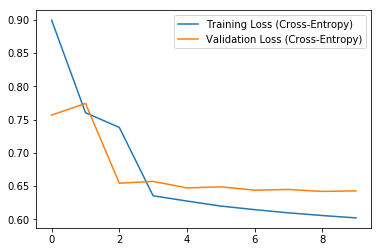

In [31]:
plt.plot(losses['train'], label='Training Loss (Cross-Entropy)')
plt.plot(losses['validation'], label='Validation Loss (Cross-Entropy)')
plt.legend();

# Hyperparameter optimization

In [32]:
from skopt.space import Real, Integer, Categorical
from IPython.display import clear_output, display

n_calls = 200

param_order = [
    'learning_rate',
    'weight_decay',
    'epochs',
    'layers',
    'dropouts',
    'embedding_dropout',
    'use_batch_norm'
]

dimensions = [
    Real(1e-8, 1, name='learning_rate'),
    Real(1e-5, 1e-1, name='weight_decay'),
    Integer(5, 2500, name='epochs'),
    Categorical([(60, 60), (60, 30, 15, 10, 5), (60, 30), (60, 30, 15), (30, 15)], name='layers'),
    Real(0., 0.75, name='dropouts'),
    Real(0., 0.75, name='embedding_dropout'),
    Categorical([True, False], name='use_batch_norm')
]

@skopt.utils.use_named_args(dimensions=dimensions)
def objective(learning_rate=1e-4, weight_decay=0.04, epochs=10, layers=[10, 10], dropouts=[0.2, 0.2], 
              embedding_dropout=0.2, use_batch_norm=True):
    
    torch.cuda.empty_cache()

    layers = list(layers)
    
    # Build model
    emb_model = EimModel(emb_szs, len(conts), embedding_dropout, 1, layers, dropouts, y_range=y_range, 
                         classify=True, use_bn=use_batch_norm)
    emb_model.to(device)
    
    opt = SGD(emb_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    crit = F.binary_cross_entropy
    losses = eim_train(emb_model, model_data, opt, crit, epochs, patience=25, print_output=False, save_best=False)
    
    return(min(losses['validation']))

In [33]:
class ProgressCallback():
    def __init__(self):
        pass

    def __call__(self, res):
        calls = len(res['func_vals'])
        clear_output()
        print('\rCompleted trial {}/{}'.format(calls, n_calls))

In [52]:
progress_callback = ProgressCallback()
opt_results = skopt.gp_minimize(objective, dimensions, n_calls=n_calls, callback=[progress_callback])

Completed trial 200/200


## Save hyperparameter optimization results

In [53]:
from skopt import dump
dump(opt_results, Path('.', 'opt_results.pkl'))

# Train tuned model

## Get best parameters

In [54]:
from skopt import load
opt_results = load(Path('.', 'opt_results.pkl'))

In [55]:
print('Best loss: {}'.format(opt_results.fun))

Best loss: 0.5416313409805298


In [56]:
print('Parameters:')
opt_params = dict(zip(param_order, opt_results.x))
opt_params

Parameters:


{'learning_rate': 0.6293289672509483,
 'weight_decay': 1e-05,
 'epochs': 1770,
 'layers': (60, 30, 15, 10, 5),
 'dropouts': 0.43702080788159714,
 'embedding_dropout': 0.75,
 'use_batch_norm': False}

Train model with these parameters until we start to diverge

In [57]:
seed_everything()
epochs = 5000
emb_model = EimModel(emb_szs, len(conts), opt_params['embedding_dropout'], 1, list(opt_params['layers']), 
                     opt_params['dropouts'], y_range=y_range, classify=True, 
                     use_bn=opt_params['use_batch_norm'])
emb_model.to(device)
opt = SGD(emb_model.parameters(), lr=opt_params['learning_rate'], weight_decay=opt_params['weight_decay'])
losses = eim_train(emb_model, model_data, opt, crit, epochs, save_best=True)

Epoch: 1/5000, Train Loss: 0.7677889466285706, Validation Loss: 0.645383894443512
Epoch: 2/5000, Train Loss: 0.6346353888511658, Validation Loss: 0.6367133855819702
Epoch: 3/5000, Train Loss: 0.6230327486991882, Validation Loss: 0.6308196783065796
Epoch: 4/5000, Train Loss: 0.6146605610847473, Validation Loss: 0.6268526911735535
Epoch: 5/5000, Train Loss: 0.6086094379425049, Validation Loss: 0.6242337226867676
Epoch: 6/5000, Train Loss: 0.6042139530181885, Validation Loss: 0.6225517392158508
Epoch: 7/5000, Train Loss: 0.6009891629219055, Validation Loss: 0.6214858293533325
Epoch: 8/5000, Train Loss: 0.59861159324646, Validation Loss: 0.6208481788635254
Epoch: 9/5000, Train Loss: 0.596855103969574, Validation Loss: 0.6205210089683533
Epoch: 10/5000, Train Loss: 0.5955525040626526, Validation Loss: 0.6203873157501221
Epoch: 11/5000, Train Loss: 0.5945807695388794, Validation Loss: 0.620407223701477
Epoch: 12/5000, Train Loss: 0.5938642621040344, Validation Loss: 0.6204750537872314
Epoch:

## Plot training results

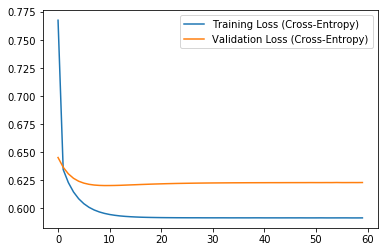

In [58]:
plt.plot(losses['train'], label='Training Loss (Cross-Entropy)')
plt.plot(losses['validation'], label='Validation Loss (Cross-Entropy)')
plt.legend();

## Load best model

In [59]:
emb_model = EimModel(emb_szs, len(conts), opt_params['embedding_dropout'], 1, list(opt_params['layers']), 
                     opt_params['dropouts'], y_range=y_range, classify=True, 
                     use_bn=opt_params['use_batch_norm'])
emb_model.to(device)
emb_model.load_state_dict(torch.load(Path('.', 'best_model.pkl')))

## Evaluate validation set against model

In [60]:
data = next(iter(model_data.val_dl))

emb_model.eval()

# get inputs
x_cats, x_conts, y = data

# wrap with variable
x_cats = torch.LongTensor(x_cats).to(device)
x_conts = torch.FloatTensor(x_conts).to(device)
y = torch.FloatTensor(y).to(device)
x_cats.requires_grad = False
x_conts.requires_grad = False
y.requires_grad = False

val_outputs = emb_model(x_cats, x_conts).cpu().detach().numpy()
val_y = y.cpu().detach().numpy()

### Plot validation AUC-PR

Average precision-recall score: 0.30


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.30')

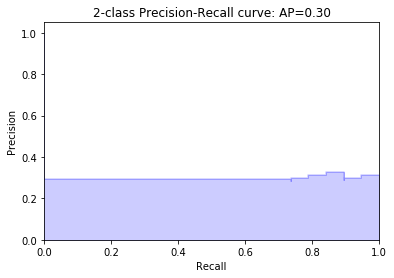

In [61]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

average_precision = average_precision_score(val_y, val_outputs)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, thresholds = precision_recall_curve(val_y, val_outputs)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

### Determine threshold for optimum F-beta / Calculate F-beta score for validation set

In [62]:
def threshold_array(threshold, array):
    array = array.copy()
    array[array >= threshold] = 1.
    array[array < threshold] = 0.
    return array

In [63]:
from sklearn.metrics import confusion_matrix, fbeta_score

In [64]:
best_fbeta = 0.0
best_fbeta_thresh = 0.0
for thresh in thresholds:
    val_outputs_thresh = threshold_array(thresh, val_outputs)
    fb = fbeta_score(val_y, val_outputs_thresh, 0.5, average='weighted')
    if fb >= best_fbeta:
        best_fbeta = fb
        best_fbeta_thresh = thresh

print('Best F_0.5 {} (at threshold {})'.format(best_fbeta, best_fbeta_thresh))

Best F_0.5 0.4255851031325864 (at threshold 0.31356489658355713)


/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Evaluate test set against model

In [65]:
test_outputs = None
for data in iter(model_data.test_dl):

    emb_model.eval()

    # get inputs
    x_cats, x_conts, y = data

    # wrap with variable
    x_cats = torch.LongTensor(x_cats).to(device)
    x_conts = torch.FloatTensor(x_conts).to(device)
    x_cats.requires_grad = False
    x_conts.requires_grad = False

    outputs = emb_model(x_cats, x_conts).cpu().detach().numpy()
    if test_outputs is not None:
        test_outputs = np.concatenate((test_outputs, outputs))
    else:
        test_outputs = outputs

### Plot test AUC-PR

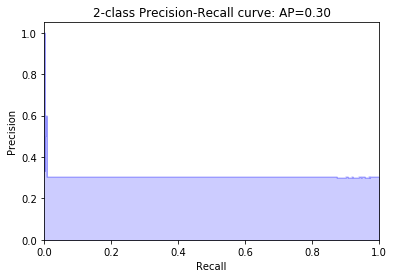

In [66]:
average_precision = average_precision_score(test_y, test_outputs)

# print('Average precision-recall score: {0:0.2f}'.format(
#       average_precision))

precision, recall, thresholds = precision_recall_curve(test_y, test_outputs)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision));

### Determine threshold for optimum F-beta / Calculate F-beta score for test set

In [67]:
best_fbeta = 0.0
best_fbeta_thresh = 0.0
for thresh in thresholds:
    test_outputs_thresh = threshold_array(thresh, test_outputs)
    fb = fbeta_score(test_y, test_outputs_thresh, 0.5, average='weighted')
    if fb >= best_fbeta:
        best_fbeta = fb
        best_fbeta_thresh = thresh

print('Best F_0.5 {} (at threshold {})'.format(best_fbeta, best_fbeta_thresh))

Best F_0.5 0.5348721416963667 (at threshold 0.3143649399280548)


## Collect CV results from multiple runs against validation and test sets

## Test results against baseline classifier

In [68]:
from sklearn.metrics import precision_recall_curve

class CustomEstimator():
    def __init__(self, cats, conts, emb_szs, embedding_dropout, layers, dropouts, y_range, use_batch_norm, lr, wd, epochs):
        self.cats = cats
        self.conts = conts
        self.emb_szs = emb_szs
        self.embedding_dropout = embedding_dropout
        self.layers = list(layers)
        self.dropouts = dropouts
        self.y_range = y_range
        self.use_batch_norm = use_batch_norm
        self.lr = lr
        self.wd = wd
        
    def fit(self, train_input, valid_input, train_y, valid_y):
        self.model = EimModel(self.emb_szs, len(self.conts), self.embedding_dropout, 1, self.layers, 
                              self.dropouts, y_range=self.y_range, classify=True, use_bn=self.use_batch_norm)
        self.model.to(device)
        self.opt = SGD(self.model.parameters(), lr=self.lr, weight_decay=self.wd)
        self.crit = F.binary_cross_entropy                
        self.epochs = epochs
        self.model_data = EimModelData.from_data_frames('./tmp', train_input, valid_input, 
                                                train_y, valid_y, cats, conts, bs=len(train_input))
        self.model.train()
        self.losses = eim_train(self.model, self.model_data, self.opt, self.crit, self.epochs, print_output=False, save_best=True, save_path='tmp_model.pkl')
        self.model.load_state_dict(torch.load(Path('.', 'tmp_model.pkl')))
    
    def score(self):
        self.model.eval()
        y, y_hat = self._get_test_outputs()
        precision, recall, thresholds = precision_recall_curve(y, y_hat)
        fbeta = self._get_best_fbeta(precision, recall, thresholds, y, y_hat)
        
        return fbeta
        
    
    def _get_test_outputs(self):
        self.model.eval()
        val_outputs = None
        ys = None
        for data in iter(self.model_data.val_dl):
            
            # get inputs
            x_cats, x_conts, y = data

            # wrap with variable
            x_cats = torch.LongTensor(x_cats).to(device)
            x_conts = torch.FloatTensor(x_conts).to(device)
            y = torch.FloatTensor(y).to(device)
            x_cats.requires_grad = False
            x_conts.requires_grad = False
            y.requires_grad = False

            outputs = self.model(x_cats, x_conts).cpu().detach().numpy()
            y = y.cpu().detach().numpy()

            if val_outputs is not None:
                val_outputs = np.concatenate((val_outputs, outputs))
                ys = np.concatenate((ys, y))
            else:
                val_outputs = outputs
                ys = y
        return (ys, val_outputs)
    
    def _get_best_fbeta(self, precision, recall, thresholds, y, y_hat):
        best_fbeta = 0.0
        best_fbeta_thresh = 0.0
        for thresh in thresholds:
            y_hat_thresh = threshold_array(thresh, y_hat)
            fb = fbeta_score(y, y_hat_thresh, 0.5, average='weighted')
            if fb >= best_fbeta:
                best_fbeta = fb
                best_fbeta_thresh = thresh
        return best_fbeta

custom_estimator = CustomEstimator(cats, conts, emb_szs, opt_params['embedding_dropout'], 
                                   opt_params['layers'], opt_params['dropouts'], y_range, 
                                   opt_params['use_batch_norm'], opt_params['learning_rate'], 
                                   opt_params['weight_decay'], opt_params['epochs'])

In [69]:
class BaselineEstimator():
    def __init__(self):
        pass
    
    def fit(self, train_input, valid_input, train_y, valid_y):
        self.valid_y = np.array(valid_y)
    
    def score(self):
        y = self.valid_y
        y_hat = np.zeros(y.shape)
        
        precision, recall, thresholds = precision_recall_curve(y, y_hat)
        fbeta = self._get_best_fbeta(precision, recall, [0.5], y, y_hat)
        
        return fbeta        
    
    def _get_best_fbeta(self, precision, recall, thresholds, y, y_hat):
        best_fbeta = 0.0
        best_fbeta_thresh = 0.0
        for thresh in thresholds:
            y_hat_thresh = threshold_array(thresh, y_hat)
            fb = fbeta_score(y, y_hat_thresh, 0.5, average='weighted')
            if fb >= best_fbeta:
                best_fbeta = fb
                best_fbeta_thresh = thresh
        return best_fbeta
    
baseline_estimator = BaselineEstimator()

In [70]:
def paired_ttest_5x2cv(estimator1, estimator2, X_train, 
                       X_valid,
                       y_train,
                       y_valid):
    """
    Adapted from: http://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_5x2cv/
    Original paper: https://sci2s.ugr.es/keel/pdf/algorithm/articulo/dietterich1998.pdf
    """
    
    from scipy import stats
    
    variance_sum = 0.
    first_diff = None

    def score_diff(X_1, X_2, y_1, y_2):

        estimator1.fit(X_1, X_2, y_1, y_2)
        estimator2.fit(X_1, X_2, y_1, y_2)
        est1_score = estimator1.score()
        est2_score = estimator2.score()
        score_diff = est1_score - est2_score
        return {
            'custom': est1_score,
            'baseline': est2_score,
            'score_diff': score_diff
        }
    
    scores = {
        'custom': [],
        'baseline': []
    }

    for i in range(5):
        
        train_idxs = np.random.choice(np.array(y_train.index), len(y_train.index)//2)
        valid_idxs = np.random.choice(np.array(y_valid.index), len(y_valid.index)//2)
        
        X_1, X_2  = X_train.iloc[train_idxs], X_valid.iloc[valid_idxs]
        y_1, y_2  = y_train.iloc[train_idxs], y_valid.iloc[valid_idxs]

        print('Iteration {}'.format(i+1))

        score_diff_1 = score_diff(X_1, X_2, y_1, y_2)
        score_diff_2 = score_diff(X_2, X_1, y_2, y_1)
        score_mean = (score_diff_1['score_diff'] + score_diff_2['score_diff']) / 2.
        score_var = ((score_diff_1['score_diff'] - score_mean)**2 +
                     (score_diff_2['score_diff'] - score_mean)**2)
        variance_sum += score_var
        if first_diff is None:
            first_diff = score_diff_1['score_diff']
        
        scores['custom'].append(score_diff_1['custom'])
        scores['custom'].append(score_diff_2['custom'])
        scores['baseline'].append(score_diff_1['baseline'])
        scores['baseline'].append(score_diff_2['baseline'])

    scores['means'] = {
       'custom': np.mean(scores['custom']),
       'baseline': np.mean(scores['baseline'])
    }
    
    numerator = first_diff
    denominator = np.sqrt(1/5. * variance_sum)
    t_stat = numerator / denominator

    pvalue = stats.t.sf(np.abs(t_stat), 5)*2.
    return {
        't_stat': float(t_stat),
        'pvalue': float(pvalue),
        'scores': scores
    }

In [71]:
paired_ttest_5x2cv(custom_estimator, baseline_estimator, train_input, valid_input, train_y, valid_y)

Iteration 1
Early stopping
Early stopping
Iteration 2
Early stopping
Early stopping
Iteration 3
Early stopping
Early stopping
Iteration 4
Early stopping
Early stopping
Iteration 5
Early stopping
Early stopping


{'t_stat': 2.6711026446407384,
 'pvalue': 0.044289905204170116,
 'scores': {'custom': [0.8666666666666667,
   0.616666854191748,
   0.7854089484183528,
   0.6899763752492805,
   0.6666666666666666,
   0.6339754937076572,
   0.7609084806444396,
   0.7148564352236269,
   0.7840531561461794,
   0.6290438370106503],
  'baseline': [0.5212765957446809,
   0.5167653706405745,
   0.5212765957446809,
   0.6591705198262574,
   0.6165501165501166,
   0.46178711613945966,
   0.5212765957446809,
   0.6100984735193702,
   0.5212765957446809,
   0.505560013756735],
  'means': {'custom': 0.7148222913925268, 'baseline': 0.5455037993411237}}}

Two-tailed t-test confirms significant difference between average $F_{0.5}$ scores of these two classifiers.